In [1]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, current_mirror_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
import matplotlib.ticker as ticker
import random

from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

In [2]:
sweep_size = 5

vout = 1.8
vin = 1.35

vcp = np.linspace(vin, 1.7, sweep_size)

In [ ]:
M1 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            vin,
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vds'],
            [
                lengths,
                vcp,
            ],
        )

length
vds
0


In [4]:
M1.cds

array([[-1.14857690e-14, -1.14713622e-14, -1.14585129e-14,
        -1.14471467e-14, -1.14371391e-14],
       [-2.30053780e-14, -2.29198065e-14, -2.28452598e-14,
        -2.27800420e-14, -2.27231130e-14],
       [-4.52895898e-14, -4.52169026e-14, -4.51578208e-14,
        -4.51094950e-14, -4.50696764e-14],
       [-9.10601172e-14, -9.10100378e-14, -9.09722937e-14,
        -9.09434226e-14, -9.09209708e-14],
       [-1.83213284e-13, -1.83176514e-13, -1.83150639e-13,
        -1.83131952e-13, -1.83118075e-13]])

In [ ]:
vcp = np.tile(vcp, 5)
M1.L = np.repeat(lengths, sweep_size)

In [88]:
vbias = []
vdsm2 = []
for i in vcp:
    vdsm2.append(np.repeat(vout-i, sweep_size))
    vbias.append(np.linspace(i, vout+0.5, sweep_size))

vdsm2 = np.asarray(vdsm2).flatten()
vbias = np.asarray(vbias).flatten()

vgsm2 = vbias-np.repeat(vcp, sweep_size)
print(vdsm2)
print(vgsm2)

[0.45       0.45       0.45       0.45       0.45       0.45
 0.45       0.45       0.45       0.45       0.41111111 0.41111111
 0.41111111 0.41111111 0.41111111 0.41111111 0.41111111 0.41111111
 0.41111111 0.41111111 0.37222222 0.37222222 0.37222222 0.37222222
 0.37222222 0.37222222 0.37222222 0.37222222 0.37222222 0.37222222
 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333 0.29444444 0.29444444
 0.29444444 0.29444444 0.29444444 0.29444444 0.29444444 0.29444444
 0.29444444 0.29444444 0.25555556 0.25555556 0.25555556 0.25555556
 0.25555556 0.25555556 0.25555556 0.25555556 0.25555556 0.25555556
 0.21666667 0.21666667 0.21666667 0.21666667 0.21666667 0.21666667
 0.21666667 0.21666667 0.21666667 0.21666667 0.17777778 0.17777778
 0.17777778 0.17777778 0.17777778 0.17777778 0.17777778 0.17777778
 0.17777778 0.17777778 0.13888889 0.13888889 0.13888889 0.13888889
 0.13888889 0.13888889 0.13888889 0.13888889 0.13888889 0.13888889
 

In [89]:
M2 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            (0.1, 2.1, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['vds', 'vgs'],
            [
                vdsm2,
                vgsm2,
            ],
        )

vds
vgs
1


In [98]:
vcp_final = np.tile(np.repeat(vcp, sweep_size), 5)
vcp_final

array([1.35, 1.35, 1.35, ..., 1.7 , 1.7 , 1.7 ])

In [114]:
gmid_m1 = np.tile(np.repeat(M1.gmid, sweep_size), 5)
gmid_m2 = M2.gmid.flatten()

gdsid_m1 = np.tile(np.repeat(M1.gds, sweep_size), 5)/np.tile(np.repeat(M1.id, sweep_size), 5)
gdsid_m2 = M2.gds.flatten()/M2.id.flatten()

jds_m1 = np.tile(np.repeat(M1.jd, sweep_size), 5)
jds_m2 = M2.jd.flatten()

In [134]:
id = 20e-6

W_m1 = id/jds_m1
W_m2 = id/jds_m2
W = W_m1+W_m2
gm = gmid_m1*id
gds = (gdsid_m1*id*gdsid_m2*id)/(gmid_m2*id)
gain = 20*np.log10(gm/gds)

d = {"W_m1": W_m1, "W_m2": W_m2, "W": W, "gmid_m1": gmid_m1, "gmid_m2": gmid_m2,"gm": gm, "gds": gds, "gain": gain}
df = pd.DataFrame(data=d)

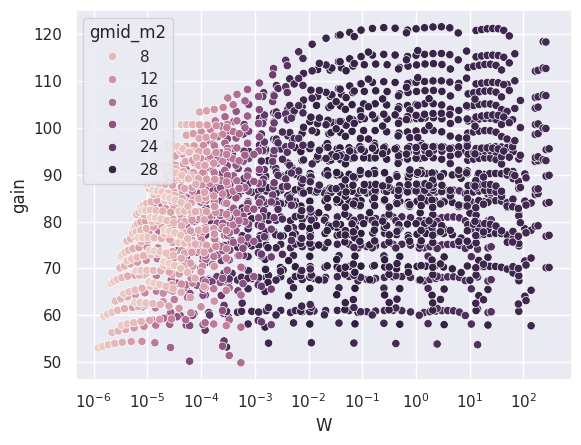

In [138]:
sns.scatterplot(data=d, x="W", y="gain", hue="gmid_m2")
plt.xscale("log")

In [ ]:
def curren_mirror_cc():
    def __init__(self, params, vcp, vin):
        self.params = params
    def build(self):

        M1 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            vin,
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vds'],
            [
                lengths,
                vcp,
            ],
        )

        self.transistor2 = Transistor(
            "../LUTs/sky130A_LUT_lvt.npy",
            'nmos',
            0,
            self.params["vds_lut2"],
            self.params["vgs_lut2"],
            self.params["length"],
            self.params["dof2"],
            [
                self.params[self.params["dof2"][0]],
                self.params[self.params["dof2"][1]],
            ],
        )

        pos = 0
        input_has_l = False
        for in_ in self.inputs["2d_var"]:
            if in_ == "length":
                self.L = np.repeat(self.inputs["length"], self.mesh[0].shape[pos])
                input_has_l = True
            else:
                pos += 1

        if not input_has_l:
            self.L = np.repeat(
                self.inputs["length"], len(self.inputs[self.inputs["2d_var"][0]])
            )


        

        self.W = self.inputs["il"] / pt_transistor.jd
        self.gdsid = pt_transistor.gds / pt_transistor.id
        self.gds = self.gdsid * self.inputs["il"]
        self.Ro = 1 / self.gds
        self.cgg = (self.W * pt_transistor.cgg) / 20e-6
        self.gm = pt_transistor.gmid * self.inputs["il"]
        self.cgs = (self.W * pt_transistor.cgs) / 20e-6
        self.cgd = (self.W * pt_transistor.cgd) / 20e-6

np.float64(60.58788961798575)

In [ ]:
sweep_size = 5

vs = np.linspace(0.1, vin-0.1, sweep_size)
vcp = np.linspace(vin, vout-0.1, sweep_size)

aux_mesh = np.meshgrid(vs, vcp)

vds_m1 = aux_mesh[1]-aux_mesh[0]
vds_m1 = vds_m1.flatten()

vgs_m1 = np.tile(vin-vs, sweep_size)

In [59]:
M1 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            (0.1, 2.1, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['vds', 'vgs'],
            [
                vds_m1,
                vgs_m1,
            ],
        )

vds
vgs
1


In [60]:
vcp = np.tile(aux_mesh[1].flatten(), 5)

vbias = []
vdsm2 = []
for i in vcp:
    vdsm2.append(np.repeat(vout-i, sweep_size))
    vbias.append(np.linspace(i, vout+0.5, sweep_size))

vdsm2 = np.asarray(vdsm2).flatten()
vbias = np.asarray(vbias).flatten()

vgsm2 = vbias-np.repeat(vcp, sweep_size)
print(vdsm2.shape)
print(vgsm2.shape)

(625,)
(625,)


In [61]:
M2 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            (0.1, 2.1, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['vds', 'vgs'],
            [
                vdsm2,
                vgsm2,
            ],
        )

vds
vgs
1


In [62]:
id = 20e-6

vcp_m1 = np.tile(np.repeat(vcp, sweep_size), 5)
vs_m1 = np.tile(np.repeat(np.tile(aux_mesh[1].flatten(), 5), sweep_size), 5)

gmid_m1 = np.tile(np.repeat(M1.gmid.flatten(), sweep_size), 5)
gmid_m2 = M2.gmid.flatten()

gdsid_m1 = np.tile(np.repeat(M1.gds.flatten(), sweep_size), 5)/np.tile(np.repeat(M1.id.flatten(), sweep_size), 5)
gdsid_m2 = M2.gds.flatten()/M2.id.flatten()

jds_m1 = np.tile(np.repeat(M1.jd, sweep_size), 5)
jds_m2 = M2.jd.flatten()

In [63]:
id = 20e-6

W_m1 = id/jds_m1
W_m2 = id/jds_m2
W = W_m1+W_m2

L_m1 = np.tile(np.repeat(np.repeat(lengths, sweep_size*sweep_size), sweep_size), 5)
L_m2 = np.repeat(lengths, len(vdsm2))
L = L_m1+L_m2

WL = W+L

gm = gmid_m1*id
gds = (gdsid_m1*id*gdsid_m2*id)/(gmid_m2*id)
gain = 20*np.log10(gm/gds)

d = {"W_m1": W_m1, "W_m2": W_m2, "WL": WL, "gmid_m1": gmid_m1, "gmid_m2": gmid_m2,"gm": gm, "gds": gds, "gain": gain, "vcp": vcp_m1, "vs": vs_m1}
df = pd.DataFrame(data=d)

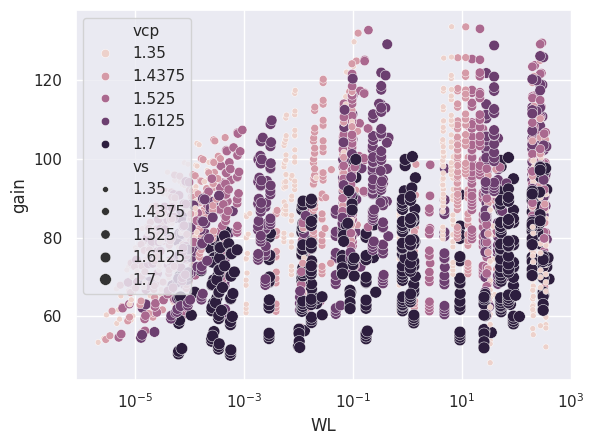

In [64]:
sns.scatterplot(data=d, x="WL", y="gain", hue="vcp", size="vs")
plt.xscale("log")

In [ ]:
def curren_mirror_cc():
    def __init__(self, vcp, vs, vin, vout, il):
        self.vcp = vcp
        self.vs = vs
        self.vin = vin
        self.vout = vout
        self.il = il
    def build(self):

        aux_mesh = np.meshgrid(self.vs, self.vcp)
        vds_m1 = aux_mesh[1]-aux_mesh[0]
        vds_m1 = vds_m1.flatten()
        vgs_m1 = np.tile(self.vin-self.vs, sweep_size)

        M1 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            (0.1, 2.1, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['vds', 'vgs'],
            [
                vds_m1,
                vgs_m1,
            ],
        )

        vcp = np.tile(aux_mesh[1].flatten(), 5)
        vbias = []
        vdsm2 = []
        for i in vcp:
            vdsm2.append(np.repeat(self.vout-i, sweep_size))
            vbias.append(np.linspace(i, self.vout+0.5, sweep_size))

        vdsm2 = np.asarray(vdsm2).flatten()
        vbias = np.asarray(vbias).flatten()
        vgsm2 = vbias-np.repeat(vcp, sweep_size)

        M2 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "nmos",
            0,
            (0.1, 2, 0.01),
            (0.1, 2.1, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['vds', 'vgs'],
            [
                vdsm2,
                vgsm2,
            ],
        )

        id = self.il

        #vcp_m1 = np.tile(np.repeat(vcp, sweep_size), 5)
        #vs_m1 = np.tile(np.repeat(np.tile(aux_mesh[1].flatten(), 5), sweep_size), 5)

        gmid_m1 = np.tile(np.repeat(M1.gmid.flatten(), sweep_size), 5)
        gmid_m2 = M2.gmid.flatten()

        gdsid_m1 = np.tile(np.repeat(M1.gds.flatten(), sweep_size), 5)/np.tile(np.repeat(M1.id.flatten(), sweep_size), 5)
        gdsid_m2 = M2.gds.flatten()/M2.id.flatten()

        jds_m1 = np.tile(np.repeat(M1.jd, sweep_size), 5)
        jds_m2 = M2.jd.flatten()

        W_m1 = id/jds_m1
        W_m2 = id/jds_m2
        #W = W_m1+W_m2

        L_m1 = np.tile(np.repeat(np.repeat(lengths, sweep_size*sweep_size), sweep_size), 5)
        L_m2 = np.repeat(lengths, len(vdsm2))
        #L = L_m1+L_m2

        #WL = W+L

        gm = gmid_m1*id
        gds = (gdsid_m1*id*gdsid_m2*id)/(gmid_m2*id)
        #gain = 20*np.log10(gm/gds)

        self.W_m1 = W_m1
        self.W_m2 = W_m2
        self.L_m1 = L_m1
        self.L_m2 = L_m2

        self.gm = gm
        self.gds = gds
        self.Ro = 1/self.gds

# cascode current mirror

In [37]:
vout = 1.7 - 3.3
sweep_size = 5

vcp = np.linspace(vout+0.1, vout+0.8, sweep_size)

M1 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "pmos",
            0,
            (-2, -0.1, 0.01),
            vin,
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['length', 'vds'],
            [
                lengths,
                vcp,
            ],
        )

length
vds
0


In [38]:
vcp = np.tile(vcp, 5)
vcp.shape

(25,)

In [1]:
vbias = []
vds_m2 = []
for i in vcp:
    vds_m2.append(np.repeat(vout-i, sweep_size))
    vbias.append(np.linspace(i-0.1, vout-0.5, sweep_size))

vds_m2 = np.asarray(vds_m2).flatten()
vbias = np.asarray(vbias).flatten()

NameError: name 'vcp' is not defined

In [49]:
vds_m2

array([-0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.275, -0.275, -0.275,
       -0.275, -0.275, -0.45 , -0.45 , -0.45 , -0.45 , -0.45 , -0.625,
       -0.625, -0.625, -0.625, -0.625, -0.8  , -0.8  , -0.8  , -0.8  ,
       -0.8  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.275, -0.275,
       -0.275, -0.275, -0.275, -0.45 , -0.45 , -0.45 , -0.45 , -0.45 ,
       -0.625, -0.625, -0.625, -0.625, -0.625, -0.8  , -0.8  , -0.8  ,
       -0.8  , -0.8  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.275,
       -0.275, -0.275, -0.275, -0.275, -0.45 , -0.45 , -0.45 , -0.45 ,
       -0.45 , -0.625, -0.625, -0.625, -0.625, -0.625, -0.8  , -0.8  ,
       -0.8  , -0.8  , -0.8  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  ,
       -0.275, -0.275, -0.275, -0.275, -0.275, -0.45 , -0.45 , -0.45 ,
       -0.45 , -0.45 , -0.625, -0.625, -0.625, -0.625, -0.625, -0.8  ,
       -0.8  , -0.8  , -0.8  , -0.8  , -0.1  , -0.1  , -0.1  , -0.1  ,
       -0.1  , -0.275, -0.275, -0.275, -0.275, -0.275, -0.45 , -0.45 ,
      

In [50]:
vgs_m2 = vbias - np.repeat(vcp, sweep_size)
vgs_m2

array([-0.1    , -0.225  , -0.35   , -0.475  , -0.6    , -0.1    ,
       -0.26875, -0.4375 , -0.60625, -0.775  , -0.1    , -0.3125 ,
       -0.525  , -0.7375 , -0.95   , -0.1    , -0.35625, -0.6125 ,
       -0.86875, -1.125  , -0.1    , -0.4    , -0.7    , -1.     ,
       -1.3    , -0.1    , -0.225  , -0.35   , -0.475  , -0.6    ,
       -0.1    , -0.26875, -0.4375 , -0.60625, -0.775  , -0.1    ,
       -0.3125 , -0.525  , -0.7375 , -0.95   , -0.1    , -0.35625,
       -0.6125 , -0.86875, -1.125  , -0.1    , -0.4    , -0.7    ,
       -1.     , -1.3    , -0.1    , -0.225  , -0.35   , -0.475  ,
       -0.6    , -0.1    , -0.26875, -0.4375 , -0.60625, -0.775  ,
       -0.1    , -0.3125 , -0.525  , -0.7375 , -0.95   , -0.1    ,
       -0.35625, -0.6125 , -0.86875, -1.125  , -0.1    , -0.4    ,
       -0.7    , -1.     , -1.3    , -0.1    , -0.225  , -0.35   ,
       -0.475  , -0.6    , -0.1    , -0.26875, -0.4375 , -0.60625,
       -0.775  , -0.1    , -0.3125 , -0.525  , -0.7375 , -0.95

In [51]:
M2 = Transistor(
            "../../LUTs/IHP_LUT_hv_20w.npy",
            "pmos",
            0,
            (-2, -0.1, 0.01),
            (-2.1, -0.1, 0.01),
            [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6],
            ['vds', 'vgs'],
            [
                vds_m2,
                vgs_m2,
            ],
        )

vds
vgs
1


In [61]:
id = 20e-6

gmid_m1 = np.tile(np.repeat(M1.gmid.flatten(), sweep_size), 5)
gmid_m2 = M2.gmid.flatten()

gdsid_m1 = np.tile(np.repeat(M1.gds.flatten(), sweep_size), 5) / np.tile(np.repeat(M1.id.flatten(), sweep_size), 5)
gdsid_m2 = M2.gds.flatten() / M2.id.flatten()

jds_m1 = np.tile(np.repeat(M1.jd, sweep_size), 5)
jds_m2 = M2.jd.flatten()

In [62]:
W_m1 = id / jds_m1
W_m2 = id / jds_m2
        # W = W_m1+W_m2

L_m1 = np.tile(
            np.repeat(
                np.repeat(lengths, sweep_size * sweep_size),
                sweep_size,
            ),
            5,
        )
L_m2 = np.repeat(lengths, len(vdsm2))
        # L = L_m1+L_m2

        # WL = W+L

gm = gmid_m1 * id
gds = (gdsid_m1 * id * gdsid_m2 * id) / (gmid_m2 * id)

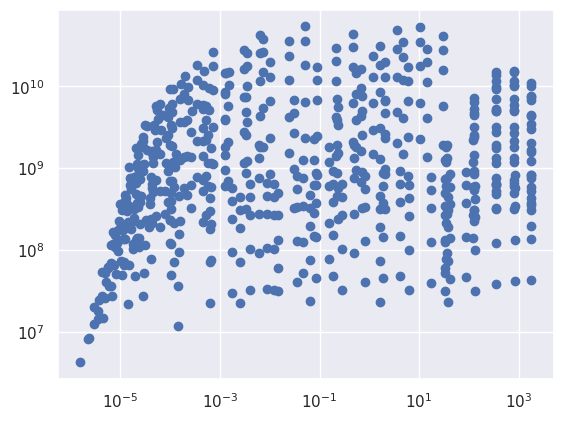

In [67]:
plt.scatter(W_m1+W_m2, 1/gds)
plt.yscale("log")
plt.xscale("log")

In [3]:
vout = 1.7 - 3.3
sweep_size = 5

vcp = np.linspace(vout+0.1, vout+0.8, sweep_size)

cm = current_mirror_cc(vcp, vout, 20e-6, sweep_size, lengths)

cm.build()

length
vds
0
vds
vgs
1


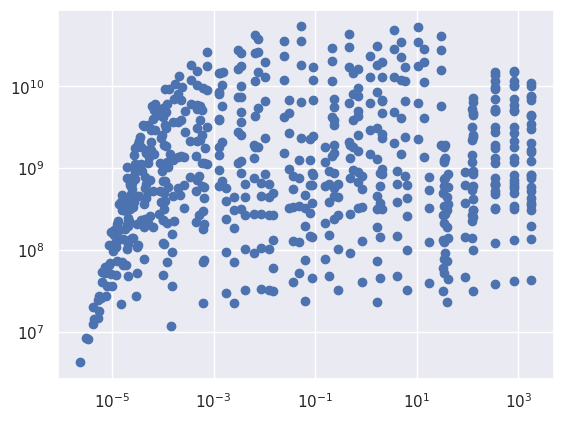

In [9]:
plt.scatter(cm.W_m1+cm.W_m2+cm.L_m1+cm.L_m2, 1/cm.gds)
plt.xscale("log")
plt.yscale("log")

In [ ]:
## PASS TRANSISTOR PRIMITIVE ###############################################################

pt_wc = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': 4.5e-6,
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt_wc.build()

pt_wc.parameters = {Symbol('gm_pt'): np.asarray(pt_wc.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt_wc.Ro).flatten(),
                 Symbol("Cgs_pt"): np.asarray(pt_wc.cgg).flatten()+np.asarray(pt_wc.cgd).flatten()*np.asarray(pt_wc.gm).flatten()*np.asarray(pt_wc.Ro).flatten(),
                 Symbol("Cgd"): np.asarray(pt_wc.cgd).flatten()}
pt_wc.outputs = {Symbol("W_pt"): np.asarray(pt_wc.W).flatten(),
              Symbol("L_pt"): np.asarray(pt_wc.L).flatten()}

In [2]:
import sys

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

In [3]:
def get_parameters(self, lengths_m):
        self.pt_lutable = LoadMosfet(
            lookup_table=self.lookup_table,
            mos=self.mos_type,
            vsb=self.vsb,
            vds=self.vds,
            vgs=self.vgs,
            lengths=lengths_m,
        )

        expressions = [
            self.pt_lutable.lengths_expression,
            self.pt_lutable.vgs_expression,
            self.pt_lutable.vds_expression,
        ]

        jd = self.pt_lutable.interpolate(
            x_expression=expressions[self.eof[0]],
            x_value=self.dof_values[0],
            y_expression=expressions[self.eof[1]],
            y_value=self.dof_values[1],
            z_expression=self.pt_lutable.current_density_expression,
        )

In [339]:
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_hv_20w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=-2.1,
            vgs=(-2.5, -0.1, 0.01),
            lengths=lengths,
        )

In [347]:
id = 10e-3
vgs = np.linspace(-2.4, -0.1, 50)

gmid = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs,
            y_expression=pt_lutable.lengths_expression,
            y_value=lengths,
            z_expression=pt_lutable.gmid_expression,
        )

vth = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs,
            y_expression=pt_lutable.lengths_expression,
            y_value=lengths,
            z_expression=pt_lutable.vth_expression,
        )

jd = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs,
            y_expression=pt_lutable.lengths_expression,
            y_value=lengths,
            z_expression=pt_lutable.current_density_expression,
        )

In [348]:
d = {'vgs': np.repeat(vgs,5), 'gmid': gmid.flatten(), 'vth': vth.flatten(), 'vdsat': np.asarray(2/gmid).flatten(), 'lengths': np.tile(lengths, 50), 'W': np.asarray(id/jd).flatten()}
df = pd.DataFrame.from_dict(d)

In [349]:
df[(df['vdsat']<0.6)].sort_values(by='W')

,vgs,gmid,vth,vdsat,lengths,W
130,-1.179592,3.361400,0.606382,0.594990,4.000000e-07,0.000697
135,-1.132653,3.648363,0.605750,0.548191,4.000000e-07,0.000822
140,-1.085714,3.980295,0.605119,0.502475,4.000000e-07,0.000983
145,-1.038776,4.368245,0.604487,0.457850,4.000000e-07,0.001195
150,-0.991837,4.827074,0.603855,0.414330,4.000000e-07,0.001483
...,...,...,...,...,...,...
243,-0.146939,23.410568,0.675349,0.085432,3.200000e-06,130605.692689
247,-0.100000,22.979782,0.669222,0.087033,1.600000e-06,165775.679125
244,-0.146939,22.871867,0.677192,0.087444,6.400000e-06,278070.356303
248,-0.100000,22.021381,0.674844,0.090821,3.200000e-06,381329.251741


In [63]:
2487e-6/90e-6

27.633333333333333

In [391]:
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_hv_20w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=-1.5,
            vgs=(-2.5, -0.1, 0.01),
            lengths=lengths,
        )

In [445]:
id_1 = 100e-3
vgs_1 = -1.6

gmid_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_1,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.gmid_expression,
        )
jd_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_1,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.current_density_expression,
        )

gds_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_1,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.gds_expression,
        )

print(gmid_1*id_1)
print(jd_1)
print(id_1/jd_1)
print(gds_1)

[[0.1858436]]
[[40.19994062]]
[[0.00248757]]
[[3.97952188e-05]]


In [446]:
id_2 = 90e-6
jd_2 = id_2*jd_1/id_1

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.vgs_expression,
        )

gmid = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.gmid_expression,
        )

print(id_2/jd_2)
print(vgs_2)
print(gmid*id_2)

[[0.00248757]]
[[-0.5249683]]
[[0.00211703]]


In [437]:
100e-3/1.47e-3

68.02721088435375

In [364]:
0.16543718/0.0185395

8.92349739744869

In [410]:
1.47e-3/0.002487

0.5910735826296742

In [17]:
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_hv_20w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='nmos',
            vsb=0,
            vds=1.7-1.4166,
            vgs=(0.1, 2, 0.01),
            lengths=lengths,
        )

In [18]:
id = 10e-6

gmid_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=2.2-1.4166,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.8e-6,
            z_expression=pt_lutable.gmid_expression,
        )

In [19]:
gmid_1*id

array([[0.00010449]])

In [20]:
pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='nmos',
            vsb=0,
            vds=2.77-1.4166,
            vgs=(0.1, 2, 0.01),
            lengths=lengths,
        )

In [21]:
gmid_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=2.2-1.4166,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.8e-6,
            z_expression=pt_lutable.gmid_expression,
        )

In [23]:
gmid_1*id

array([[0.00010191]])

In [75]:
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_hv_20w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=(-2.4, -0.1, 0.01),
            vgs=(-2.5, -0.1, 0.01),
            lengths=6.4e-6,
        )

In [95]:
id_1 = 10e-6
vds = np.linspace(-1.1, -0.1, 5)

gmid_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=1.7-3.3,
            y_expression=pt_lutable.vds_expression,
            y_value=2.923-3.3,
            z_expression=pt_lutable.gmid_expression,
        )

jd_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=1.7-3.3,
            y_expression=pt_lutable.vds_expression,
            y_value=2.923-3.3,
            z_expression=pt_lutable.current_density_expression,
        )

In [96]:
print(gmid_1*id_1)
print(jd_1)

[[1.45529357e-05]]
[[1.50675234]]


In [97]:
id_1 = 10e-6
vds = np.linspace(-1.1, -0.1, 5)

gmid = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=1.7-3.3,
            y_expression=pt_lutable.vds_expression,
            y_value=2.94-3.3,
            z_expression=pt_lutable.gmid_expression,
        )

In [98]:
gmid*id_1

array([[1.42553031e-05]])

In [87]:
id_1/1.5

6.6666666666666675e-06

In [3]:
lookup_table = load_lookup_table('../../LUTs/IHP_LUT_hv_20w.npy')

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=-1.5,
            vgs=(-2.5, -0.1, 0.01),
            lengths=lengths,
        )

In [4]:
id_1 = 100e-3
vgs_1 = -1.6

gmid_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_1,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.gmid_expression,
        )
jd_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_1,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.current_density_expression,
        )

gds_1 = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_1,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.gds_expression,
        )

print(gmid_1*id_1)
print(jd_1)
print(id_1/jd_1)
print(gds_1)

[[0.1858436]]
[[40.19994062]]
[[0.00248757]]
[[3.97952188e-05]]


In [5]:
id_2 = 9.9e-4
jd_2 = id_2*jd_1/id_1

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.vgs_expression,
        )

gmid = pt_lutable.interpolate(
            x_expression=pt_lutable.vgs_expression,
            x_value=vgs_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=0.4e-6,
            z_expression=pt_lutable.gmid_expression,
        )

print(id_2/jd_2)
print(vgs_2)
print(gmid*id_2)

[[0.00248757]]
[[-0.65105794]]
[[0.01427684]]
